# Murder weapons

In [2]:
import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Load the sparse transcript count matrix

The count matrix is of the format:

    %
    no_genes no_cells no_counts
    19 1 1
    34 1 1
    [...]
    33663 12318 1
    33665 12318 35
    33678 12318 1

where the first number represents the gene, the second number represents the cell, and the third number represents the count.

First, we will load the data into a matrix called ``matrix``, accessing the count as ``matrix[gene][cell]``.
    

In [ ]:
matrix = None

with open("matrix.mtx", "r") as f:
    first_line = True
    
    for line in f:
        if "%" in line:
            continue
        
        line = [int(i) for i in line.rstrip().split()]
        
        if first_line:
            genes, cells, count = line
            first_line = False
            matrix = np.ndarray(shape=(genes,cells))
        else:
            genes, cells, count = line
            matrix[genes-1, cells-1] = count

In [ ]:
matrix.shape

Note, we first index by genes (33694), and then by cells (12318)

# Load batch labels

Load batch barcode data. It is of the format:

    AAACCTGAGACATAAC-1

where ``AAACCTGAGACATAAC`` is a nucleotide barcode and ``1`` is the batch it corresponds to. Load it into a Python list of lists accessed as e.g. `batches[batch][5]`, where `batch` is the batch number minus one, and `5` is the fifth barcode for that batch in the list.

In [ ]:
with open("barcodes.tsv") as f:
    batches = [[], []]
    batch_per_cell = []
    
    for i, line in enumerate(f):
        
        barcode, batch = line.rstrip("\n").split("-")
        batch = int(batch) - 1
        batches[batch].append(i)
        batch_per_cell.append(batch + 1)

As expected, the last batch label is 12317, one less than the number of cells

In [ ]:
batches[1][-1]

# Load gene ids

Load a dictionary mapping gene IDs to gene names, such as:
    
    ENSG00000277630 BX072566.1
    ENSG00000278384 AL354822.1

For example, `genes[1] = ("ENSG00000278384", "AL354822.1")`. To get all gene IDs, use `genes.keys()` and to get all gene names, use `genes.values()`.


In [ ]:
genes = []

with open("genes.tsv") as f:
    for id_gene in f:
        
        gene_id, gene_name = id_gene.split()
        genes.append((gene_id, gene_name))

As expected, the number of genes is equal to the number of genes.

In [ ]:
len(genes)

# Check if there is a significant coverage disparity between batches

In [ ]:
batch_1 = matrix[:,batches[0]]

In [ ]:
batch_2 = matrix[:,batches[1]]

In [ ]:
cell_count_1 = batch_1.sum(0)

In [ ]:
cell_count_2 = batch_2.sum(0)

This is the number of cells in the first batch

In [ ]:
len(cell_count_1)

This is the number of cells in the second batch

In [ ]:
len(cell_count_2)

# Scale histograms by the number of cells

In [ ]:
len(cell_count_1)//50

In [ ]:
len(cell_count_2)//50

In [ ]:
plt.hist(cell_count_1, bins=len(cell_count_1)//50, histtype='step')
plt.hist(cell_count_2, bins=len(cell_count_2)//50, histtype='step', color="r")
pass

# Underscale the first batch

In [ ]:
plt.hist(cell_count_1, bins=len(cell_count_1)//80, histtype='step')
plt.hist(cell_count_2, bins=len(cell_count_2)//50, histtype='step', color="r")
pass

# Let's convert our data into scanpy format

Our `matrix` will now be transposed, that is, it will be accessed as `matrix[cell][gene]`.

In [ ]:
matrix = matrix.T

In [ ]:
matrix.shape

In [ ]:
gene_annotation = pandas.DataFrame({"gene_names": [gene[0] for gene in genes], "gene_ids": [gene[1] for gene in genes]})

In [ ]:
gene_annotation.shape

In [ ]:
batch_annotation = pandas.DataFrame({"batch": batch_per_cell})

In [ ]:
batch_annotation.shape

In [ ]:
matrix = anndata.AnnData(X=matrix, obs=batch_annotation, var=gene_annotation)

In [ ]:
batch_1.shape

In [ ]:
batch_2.shape

In [ ]:
batch_1 = anndata.AnnData(X=batch_1.T, var=gene_annotation)

In [ ]:
batch_2 = anndata.AnnData(X=batch_2.T, var=gene_annotation)

In [ ]:
batch_1, batch_2, matrix

# Running scanpy analysis

In [ ]:
frames = batch_1, batch_2, matrix

In [ ]:
for frame in frames:
    frame.var_names = [gene[1] for gene in genes]
    frame.var_names_make_unique()

matrix.obs_names = [str(batch) for batch in batch_per_cell]
matrix.obs_names_make_unique()
batch_1.obs_names = ["1" for _ in range(len(batch_1))]
batch_1.obs_names_make_unique()
batch_2.obs_names = ["2" for _ in range(len(batch_2))]
batch_2.obs_names_make_unique()



# Standard analysis follows
We'll just set adata to matrix

In [ ]:
adata = matrix

# Clustering 3K PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.  
    
The data consists in *3K PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [ ]:
sc.settings.set_figure_params(dpi=80)

In [ ]:
adata

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [38]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13748 genes that are detected in less than 3 cells


Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [39]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# IS THERE A WAY TO DO THIS BY BATCH TO PROVE THAT BOTH BATCHES HAVE SIMILAR PRECENT.MITO VALUES?
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))
# add the total counts per cell as observations-annotation to adata
# AS ABOVE - PRESENT BY BATCH?
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

In [40]:
[i for i in mito_genes if i is True]

[]

In [41]:
np.sum(adata[:, mito_genes].X, axis=1)

ArrayView([401., 852., 351., ..., 583., 248., 288.], dtype=float32)

In [42]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

A violin plot of the computed quality measures.

... storing 'gene_ids' as categorical


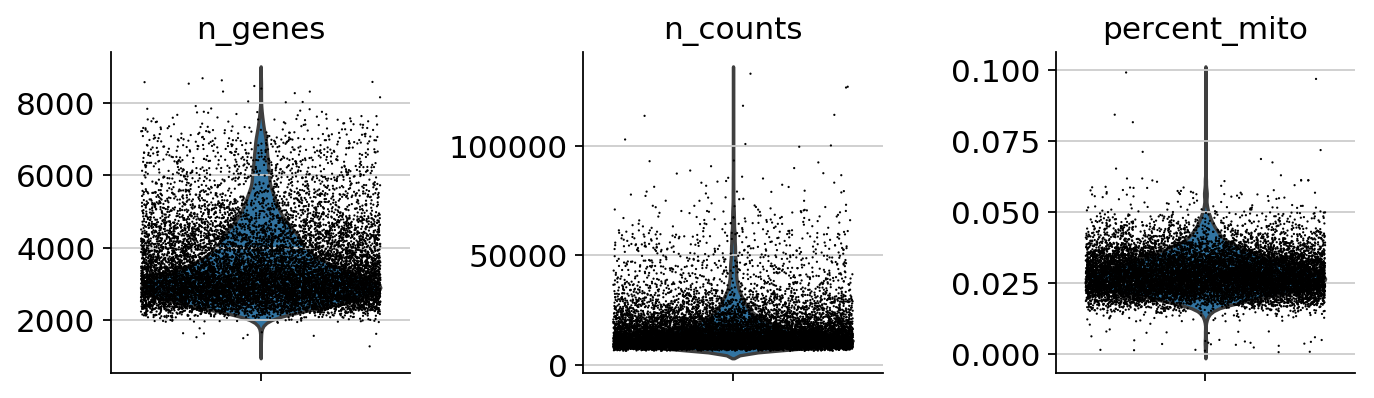

In [43]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

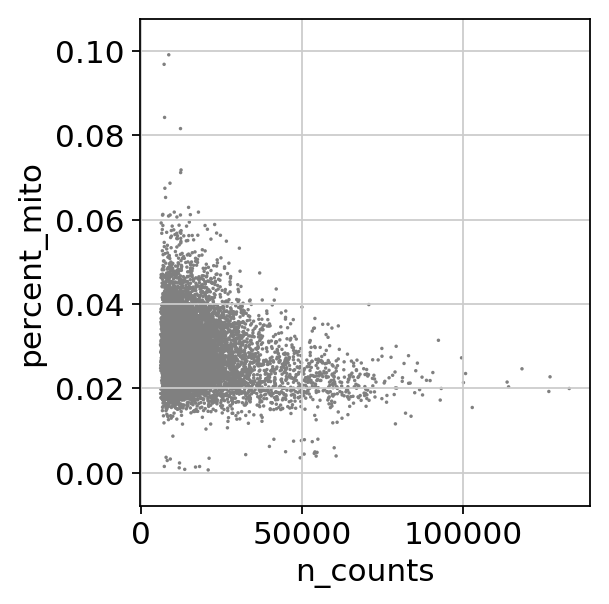

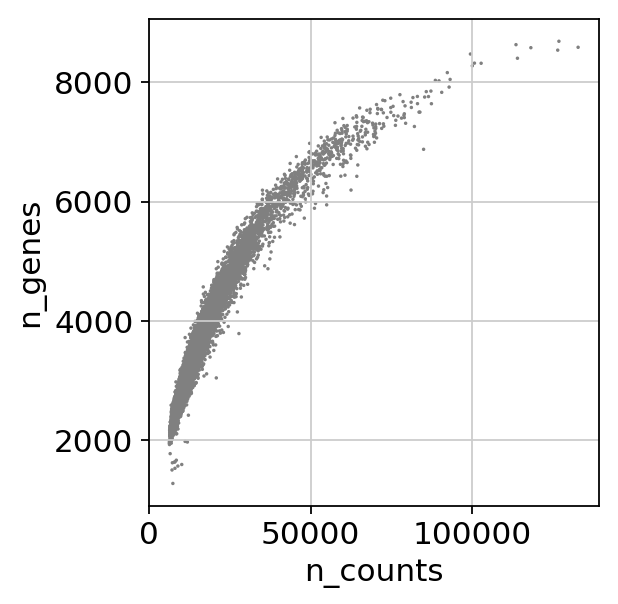

In [44]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [45]:
adata
# DISCRIMINATE BETWEEN BATCHES?

AnnData object with n_obs × n_vars = 12318 × 19946 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells'

Actually do the filtering.

In [46]:
adata = adata[adata.obs['n_genes'] < 100000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [47]:
adata

View of AnnData object with n_obs × n_vars = 12220 × 19946 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [48]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Logarithmize the data.

In [49]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [50]:
# Eats up too much memory!
# adata.raw = adata

Identify highly-variable genes.

In [51]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


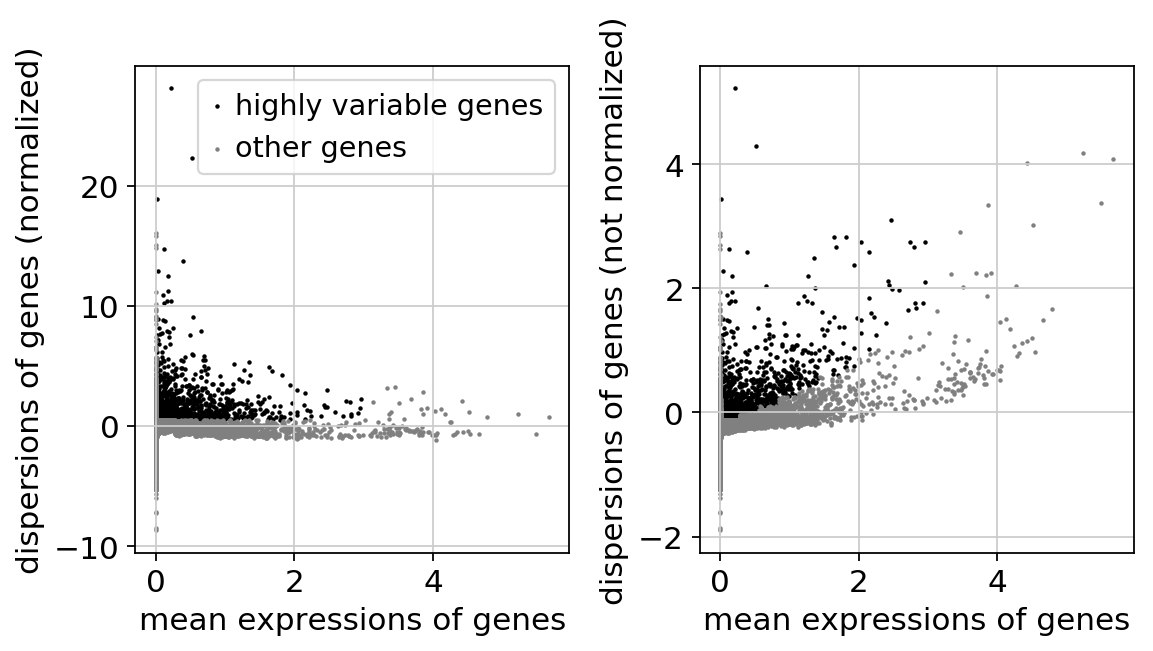

In [52]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [54]:
import collections

In [55]:
collections.Counter(adata.var["highly_variable"])

Counter({False: 18600, True: 1346})

# Filter out highly variable genes

In [56]:
adata = adata[:, adata.var['highly_variable']]

In [57]:
adata

View of AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [58]:
try:
    sc.pl.pca(adata, color='n_counts')
except:
    pass

In [59]:
sc.tl.pca(adata, svd_solver='arpack')

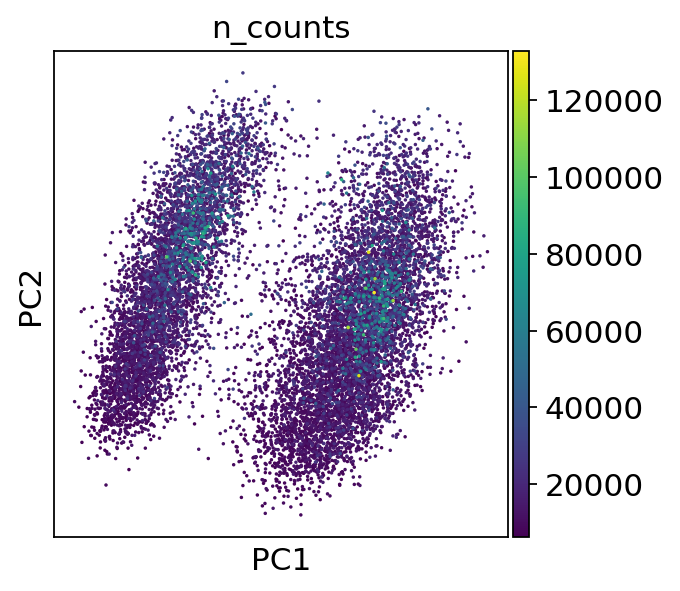

In [60]:
sc.pl.pca(adata, color='n_counts')

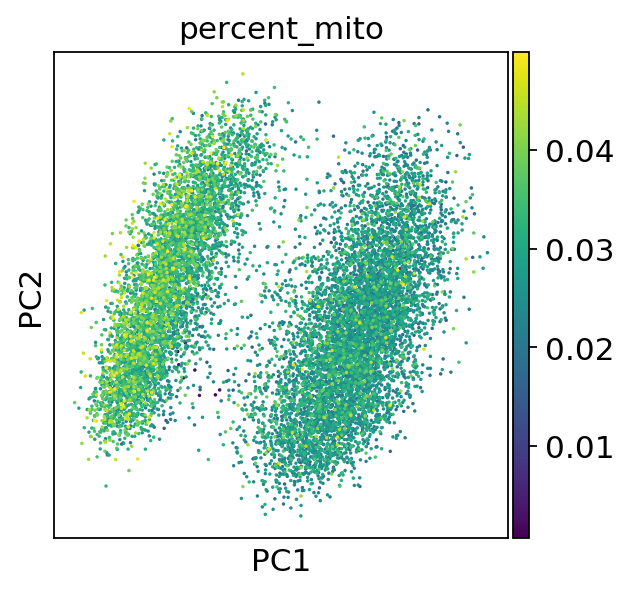

In [61]:
sc.pl.pca(adata, color='percent_mito')

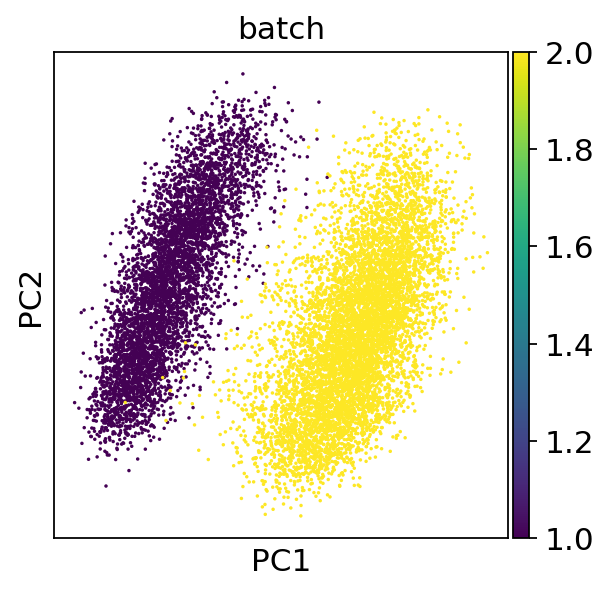

In [62]:
sc.pl.pca(adata, color='batch')

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

# Regress out counts

In [63]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    finished (0:00:09.13)


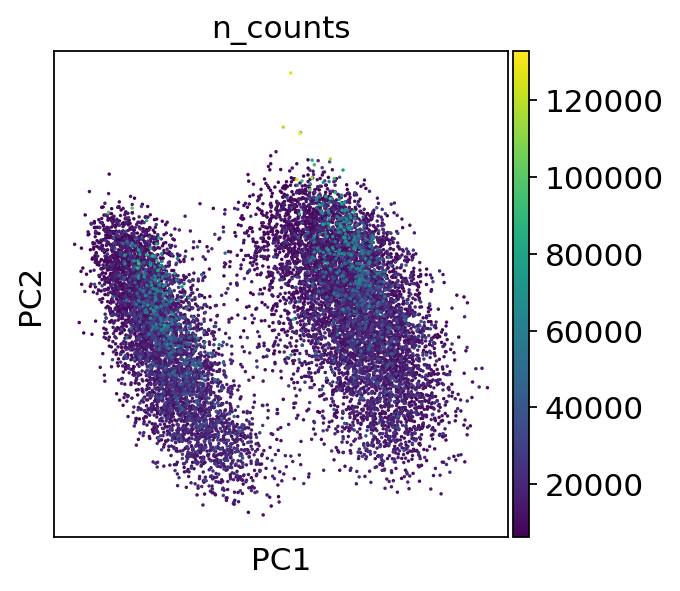

In [64]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_counts')

# Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [65]:
sc.pp.scale(adata, max_value=10)

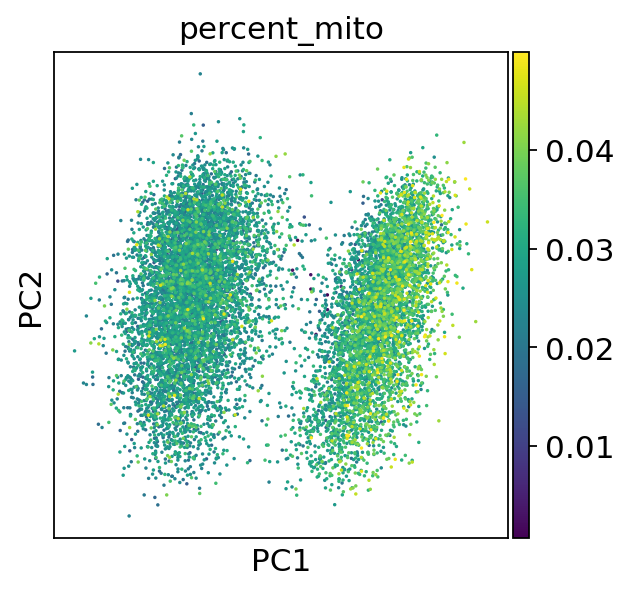

In [66]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='percent_mito')

# Regress out percent_mito

In [67]:
#sc.pp.regress_out(adata, ['percent_mito'])

In [68]:
#sc.tl.pca(adata, svd_solver='arpack')
#sc.pl.pca(adata, color='percent_mito')

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [69]:
sc.tl.pca(adata, svd_solver='arpack')

In [70]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [74]:
any(adata.var.gene_ids == "CST3")

False

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

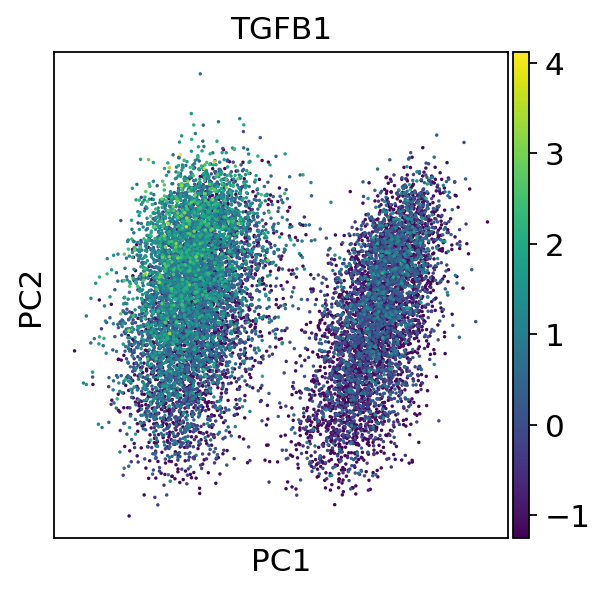

In [75]:
sc.pl.pca(adata, color='TGFB1')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

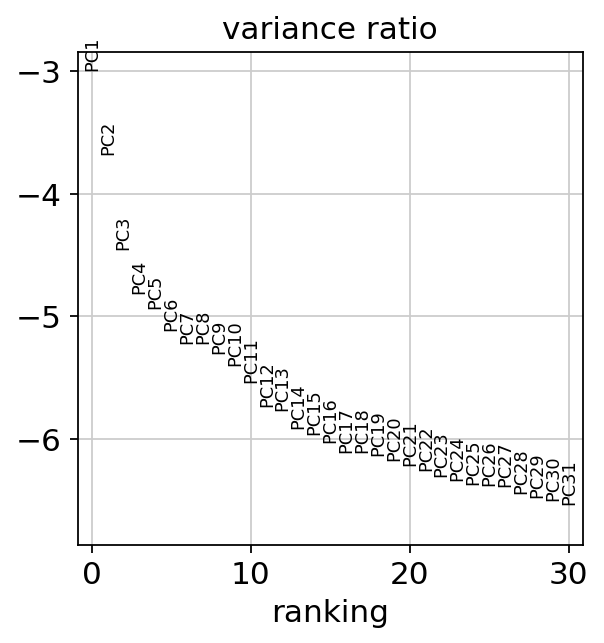

In [76]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [77]:
adata.write(results_file)

In [78]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [79]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:07.57) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [80]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:12.64) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [81]:
"TGFB1" in adata.var_names

True

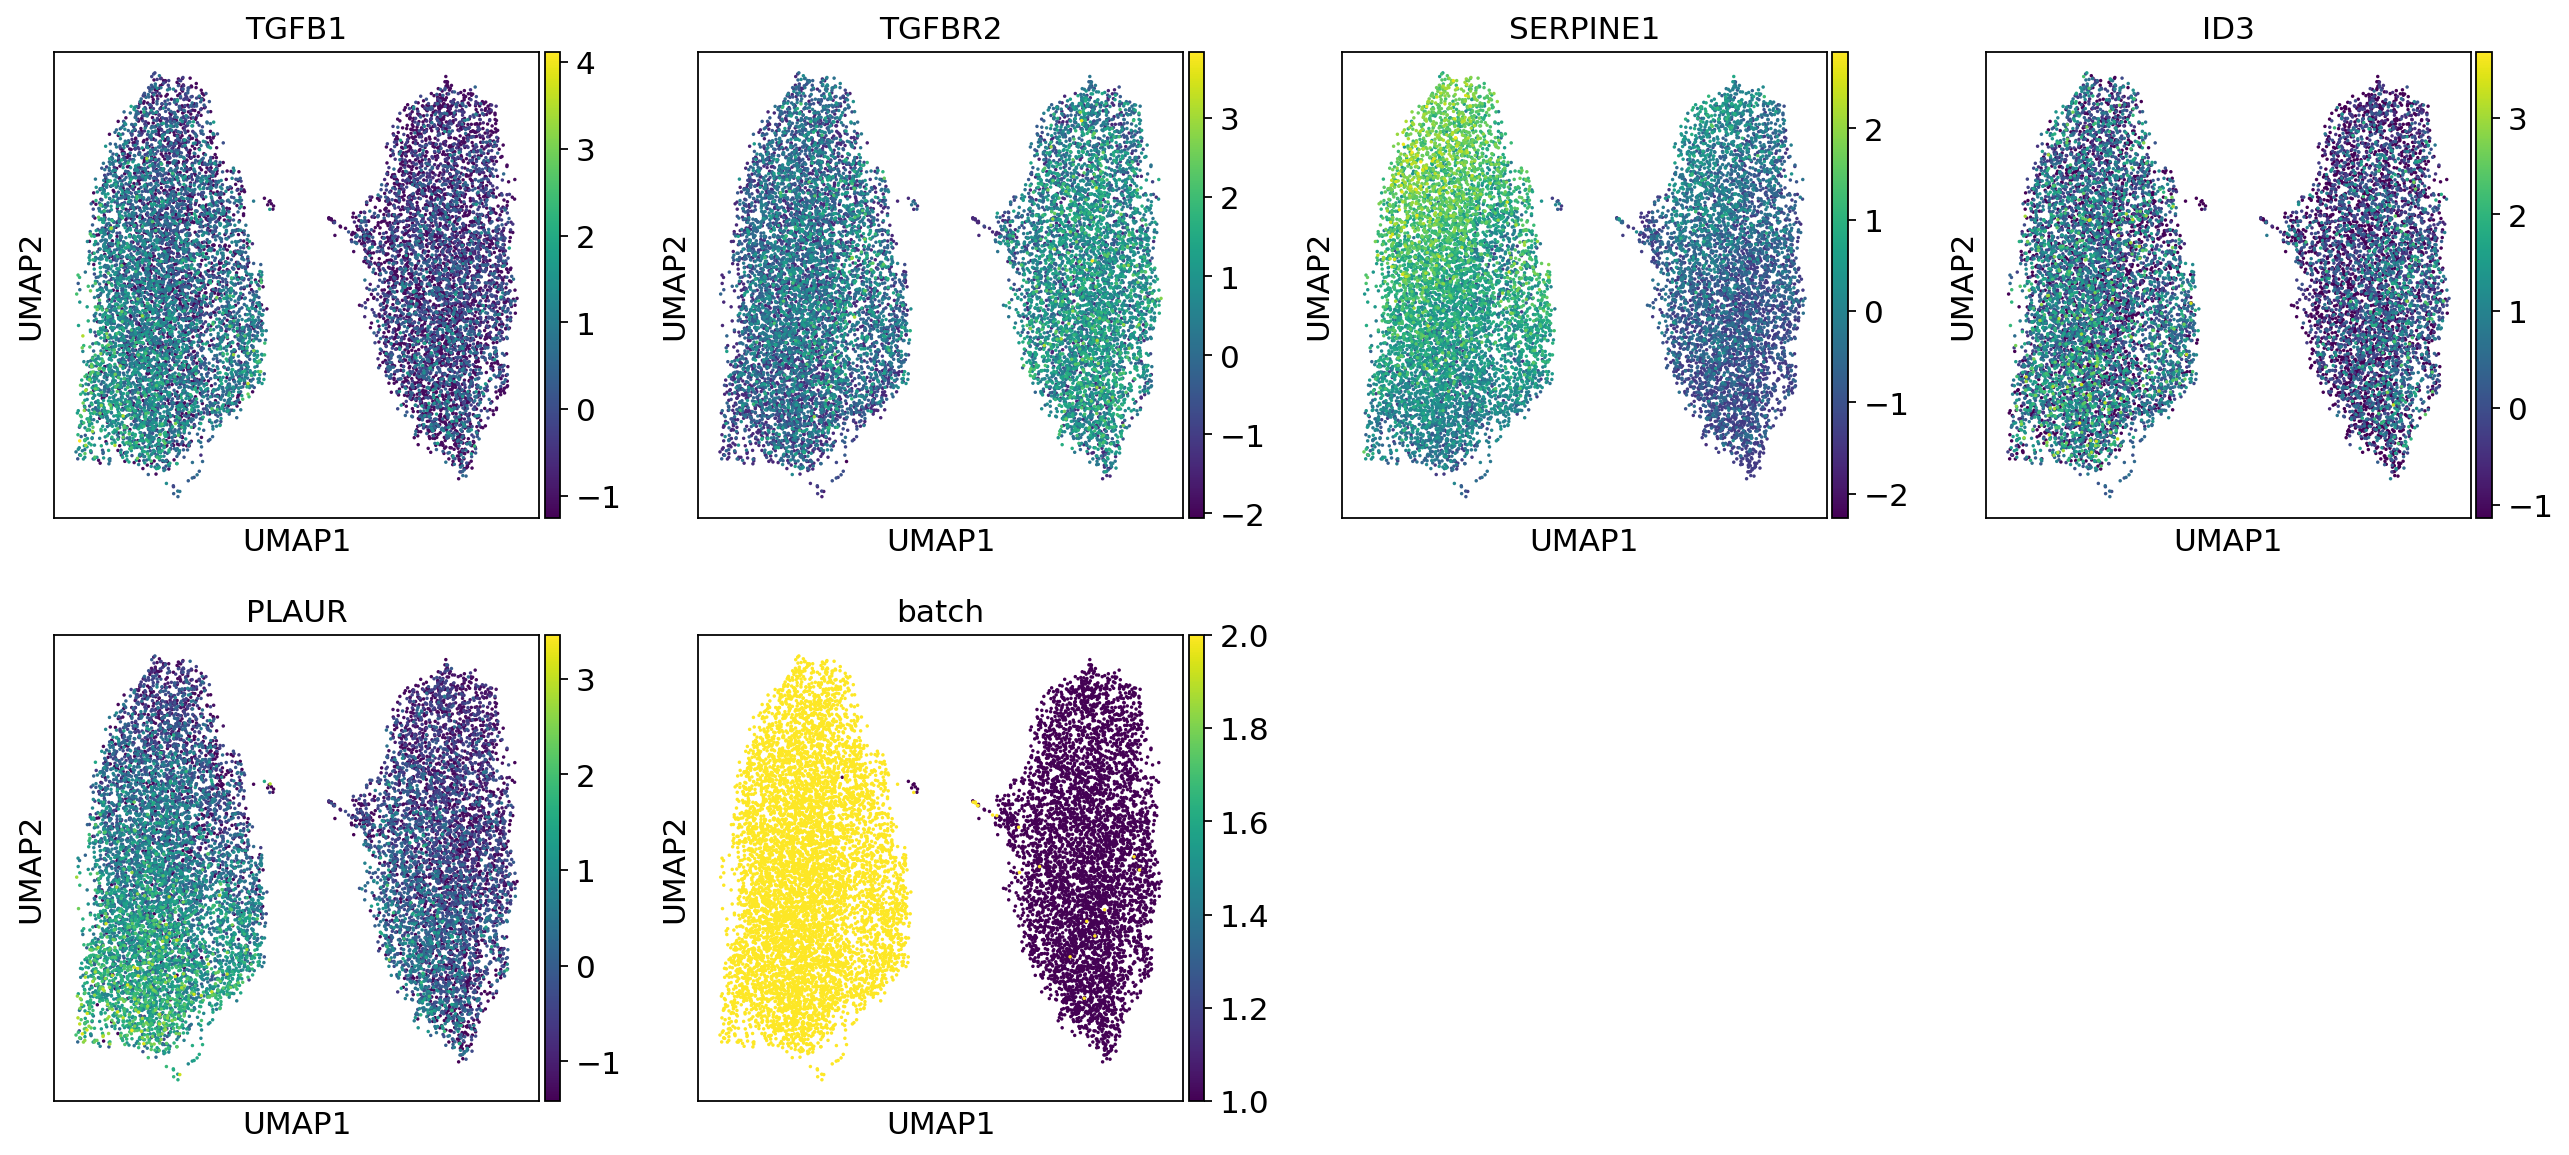

In [82]:
sc.pl.umap(adata, color=[i for i in ["TGFB1", "TGFBR1", "TGFBR2", "SERPINE1", "ID3", "PLAUR"] if i in adata.var_names] + ["batch"])

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [87]:
scanpy.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.49) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the clusters, which agree quite well with the result of Seurat.

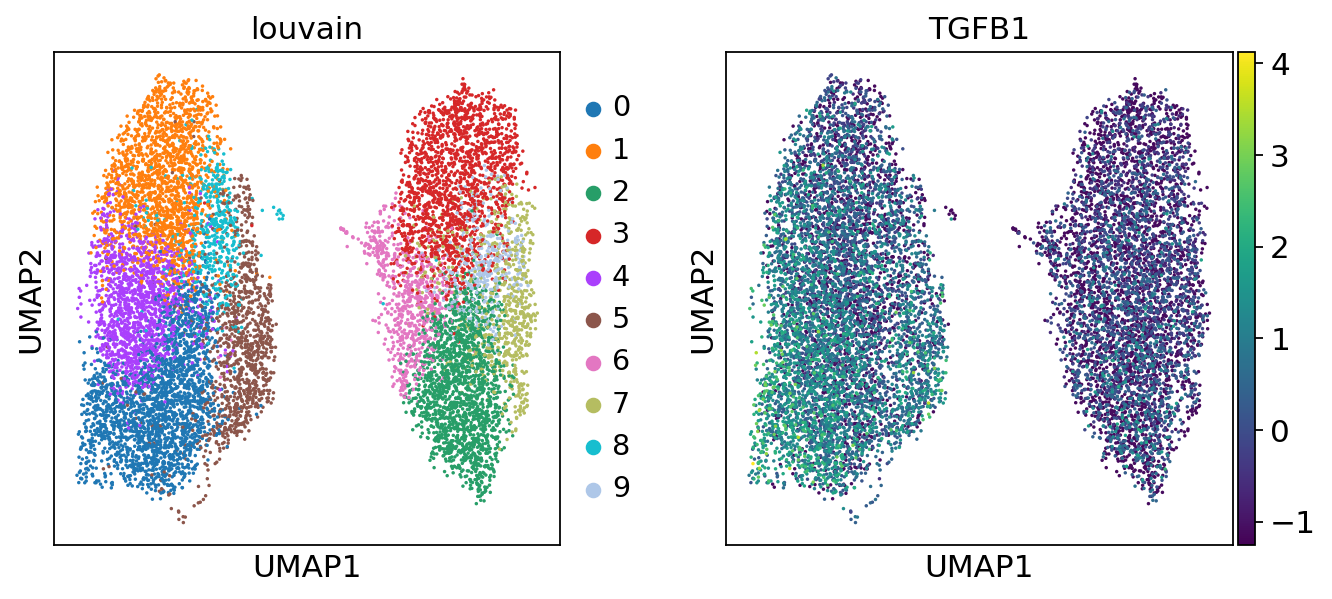

In [88]:
sc.pl.umap(adata, color=['louvain', 'TGFB1'])

Save the result.

In [89]:
adata.write(results_file)

In [1]:
import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

adata = anndata.read(results_file)

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished (0:00:00.91) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


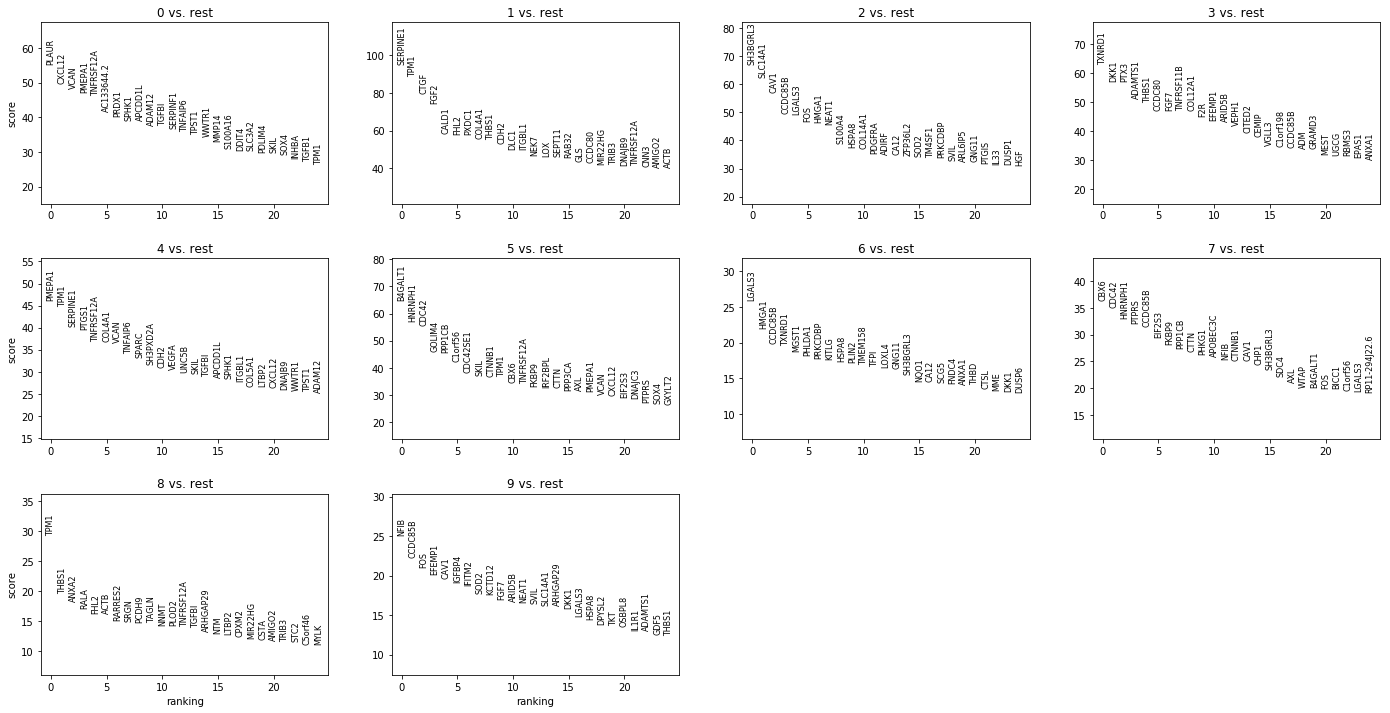

In [2]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [3]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:03.33)


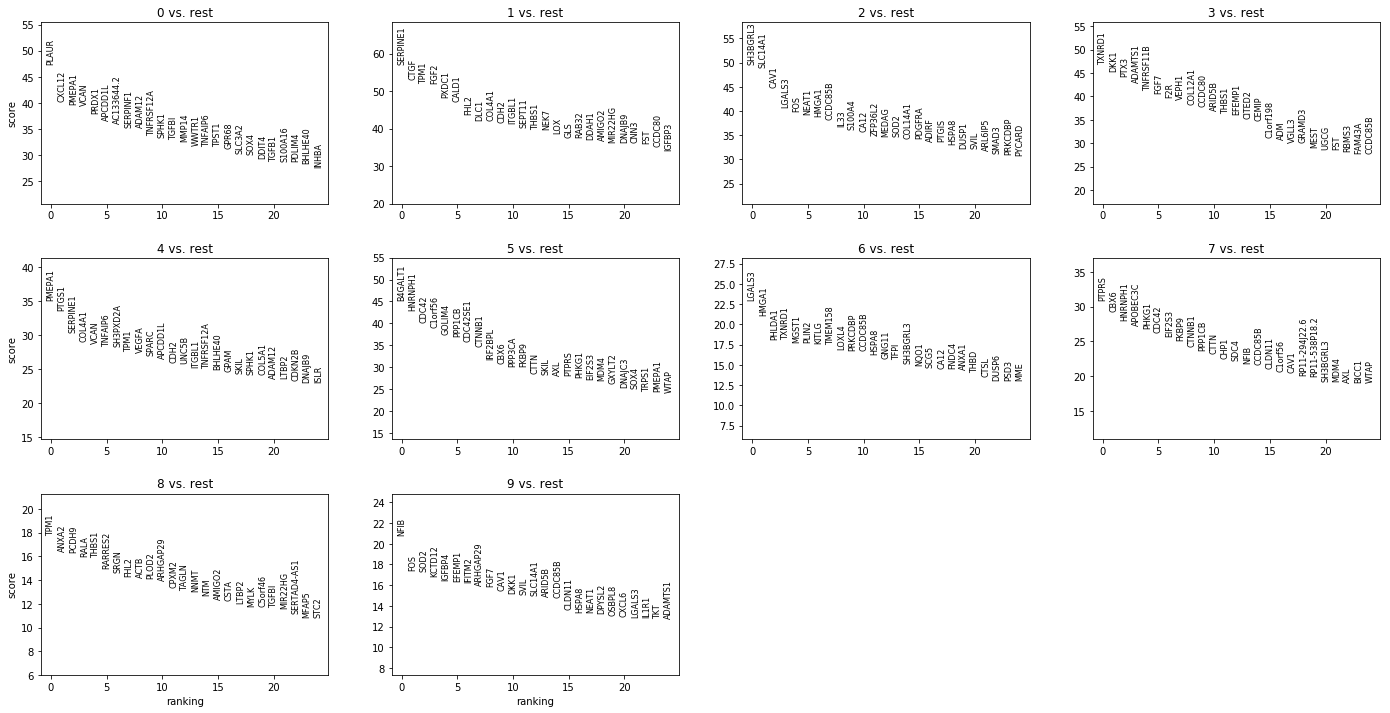

In [4]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

In [5]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [6]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Fix up the way batch is treated (it has to be str) do case control

In [7]:
batch_str = [str(i) for i in adata.obs["batch"]]

In [8]:
adata.obs["batch"] = batch_str

... storing 'batch' as categorical


ranking genes
    finished (0:00:02.56)


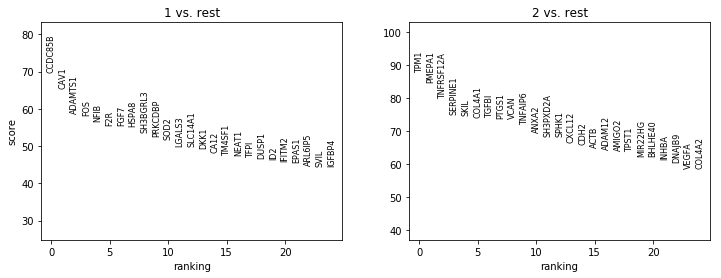

In [9]:
sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Compute our own "signature"

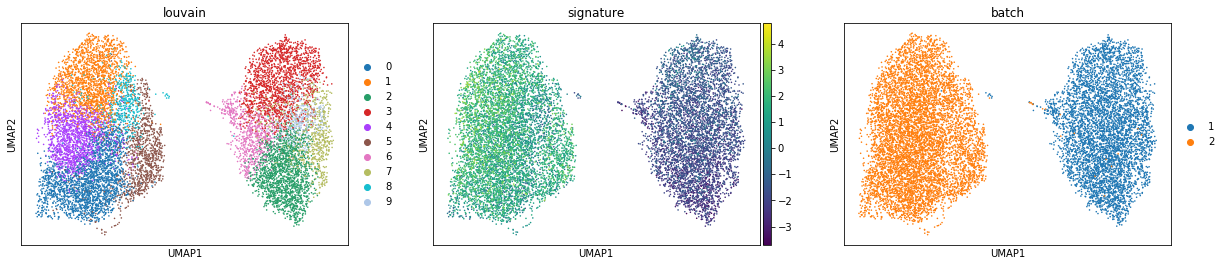

In [10]:
adata.obs["signature"] = adata[:, adata.var.gene_ids.isin(["TPM1", "PMEPA1"])].X.sum(1)
sc.pl.umap(adata, color=['louvain', 'signature', 'batch'])

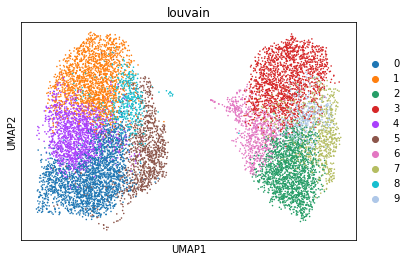

In [43]:
sc.pl.umap(adata, color='louvain')

# Doing RNA velocity
You need spliced/unspliced counts from the STAR aligner.

In [11]:
import scvelo as scv

In [13]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

In [ ]:
scv.tl.velocity_embedding(adata, basis='umap')

# Violin plots

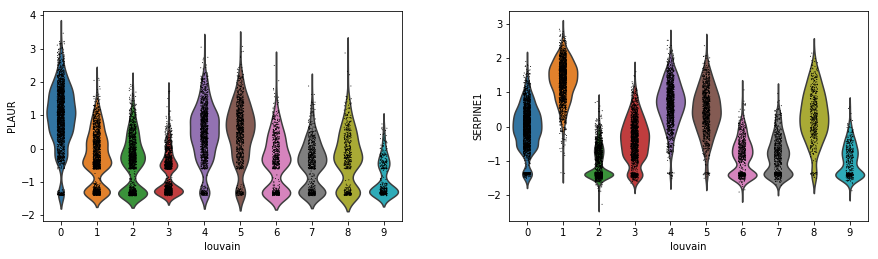

In [15]:
sc.pl.violin(adata, ['PLAUR', 'SERPINE1'], groupby='louvain')

# More ideas from the tutorial

ranking genes
    finished (0:00:03.22)


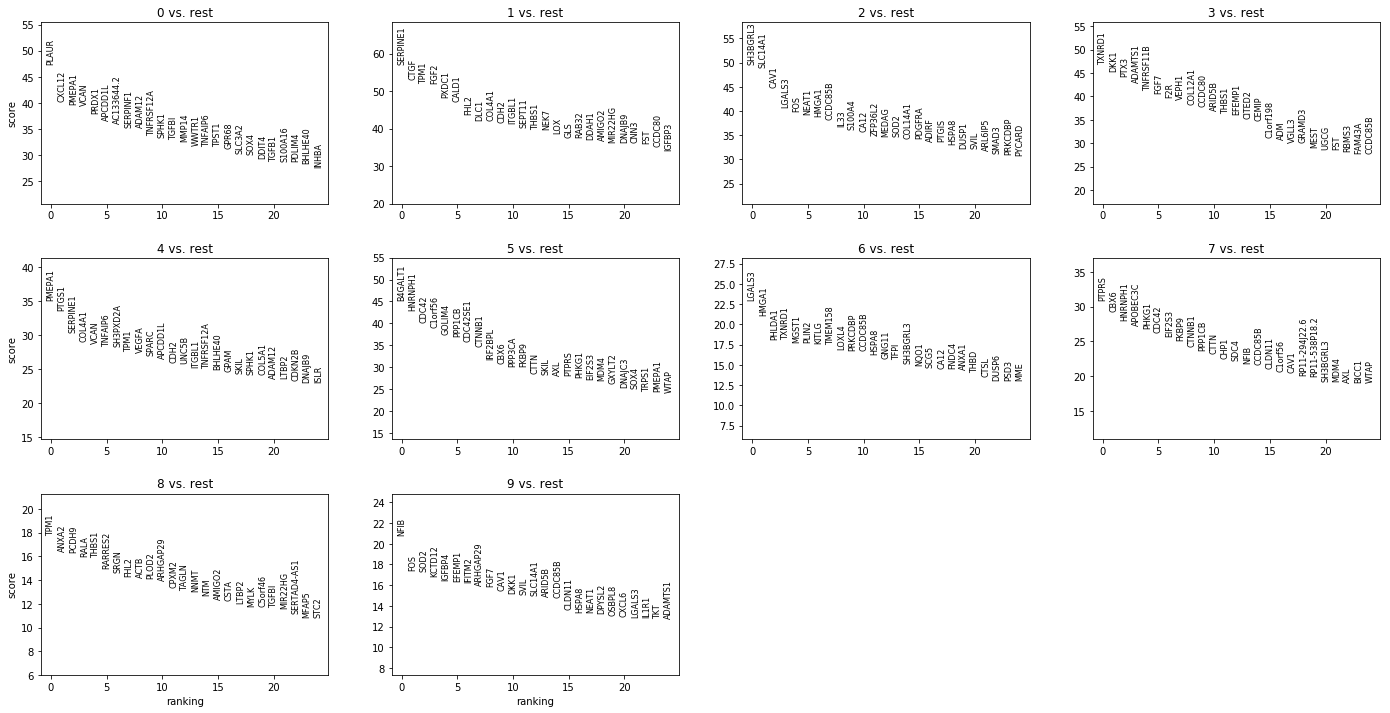

In [25]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [26]:
marker_genes = ['PLAUR', 'SERPINE1']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [27]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1         2          3         4        5       6         7  \
0   PLAUR  SERPINE1  SH3BGRL3     TXNRD1    PMEPA1  B4GALT1  LGALS3     PTPRS   
1  CXCL12      CTGF   SLC14A1       DKK1     PTGS1  HNRNPH1   HMGA1      CBX6   
2  PMEPA1      TPM1      CAV1       PTX3  SERPINE1    CDC42  PHLDA1   HNRNPH1   
3    VCAN      FGF2    LGALS3    ADAMTS1    COL4A1  C1orf56  TXNRD1  APOBEC3C   
4   PRDX1     PXDC1       FOS  TNFRSF11B      VCAN   GOLIM4   MGST1     PHKG1   

       8       9  
0   TPM1    NFIB  
1  ANXA2     FOS  
2  PCDH9    SOD2  
3   RALA  KCTD12  
4  THBS1  IGFBP4

Get a table with the scores and groups.

In [29]:
## result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p       1_n  1_p       2_n  2_p        3_n  3_p       4_n  \
0   PLAUR  0.0  SERPINE1  0.0  SH3BGRL3  0.0     TXNRD1  0.0    PMEPA1   
1  CXCL12  0.0      CTGF  0.0   SLC14A1  0.0       DKK1  0.0     PTGS1   
2  PMEPA1  0.0      TPM1  0.0      CAV1  0.0       PTX3  0.0  SERPINE1   
3    VCAN  0.0      FGF2  0.0    LGALS3  0.0    ADAMTS1  0.0    COL4A1   
4   PRDX1  0.0     PXDC1  0.0       FOS  0.0  TNFRSF11B  0.0      VCAN   

             4_p      5_n            5_p     6_n            6_p       7_n  \
0  8.883341e-272  B4GALT1   0.000000e+00  LGALS3  2.232306e-117     PTPRS   
1  7.799930e-248  HNRNPH1   0.000000e+00   HMGA1   5.624076e-99      CBX6   
2  1.128410e-203    CDC42   0.000000e+00  PHLDA1   7.166040e-74   HNRNPH1   
3  7.609172e-186  C1orf56   0.000000e+00  TXNRD1   1.588746e-73  APOBEC3C   
4  5.314131e-182   GOLIM4  1.705985e-309   MGST1   3.244848e-71     PHKG1   

             7_p    8_n           8_p     9_n           9_p  
0  5.975553e-211   TPM1  1.345494e-70    NFIB  3.367573e-96  
1  1.234613e-188  ANXA2  1.066772e-60     FOS  3.583127e-68  
2  5.263257e-173  PCDH9  3.878011e-60    SOD2  9.892908e-68  
3  1.403803e-164   RALA  1.784000e-57  KCTD12  1.733555e-63  
4  1.079435e-159  THBS1  7.939198e-57  IGFBP4  6.791237e-61

Compare to a single cluster. 

# That's comparing the two extremes in the treated group

ranking genes
    finished (0:00:00.71)


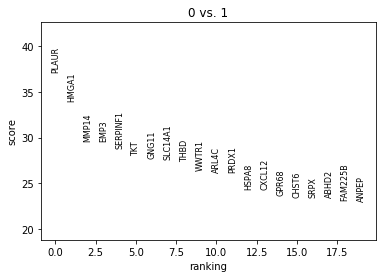

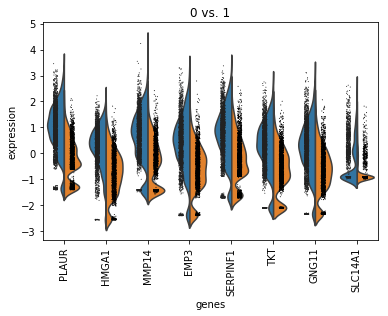

In [35]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

ranking genes
    finished (0:00:00.70)


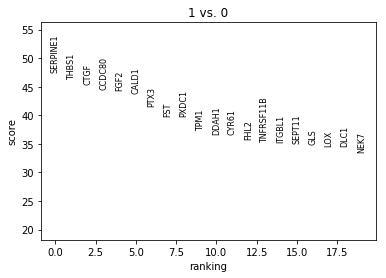

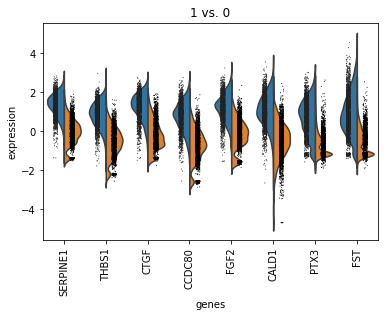

In [36]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['1'], reference='0', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [37]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes
    finished (0:00:03.21)


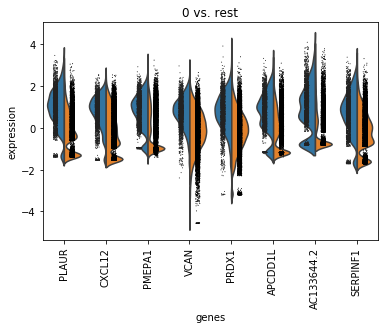

In [38]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

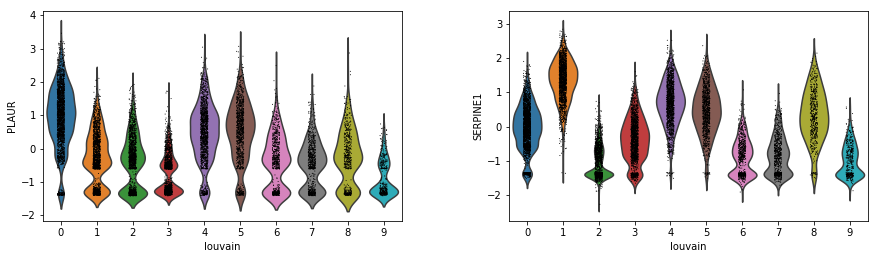

In [40]:
sc.pl.violin(adata, ['PLAUR', 'SERPINE1'], groupby='louvain')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

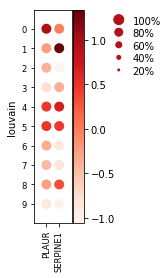

In [41]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

IndexError: list index out of range

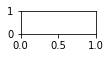

In [44]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [45]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [46]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [47]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )